In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import uproot
import fnmatch
import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi


In [126]:
#files = sorted(os.listdir(f'../muography/data/'))
target_files = fnmatch.filter(files, "four_detector_target_*_1.root")
free_files   = fnmatch.filter(files, "four_detector_free_*_1.root")
files = np.concatenate([target_files,free_files])
for j, file in enumerate(files):
    if 'merge' in file: continue
    with ur.open('~/muography/data/'+file+":events") as f:
        arrays = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", "MCParticles.PDG", "MCParticles.generatorStatus", "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", "MCParticles.vertex.x", "MCParticles.vertex.y", "MCParticles.vertex.z", "MCParticles.mass"])

    y,x=np.histogram(ak.flatten(arrays["MuographyHits.energy"]), bins=100, range=(0, 0.004))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y)])[0] 
    plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
    plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
    plt.xlabel('Cell Energy (MeV)')
    plt.legend()
    plt.close()
    
    data_energy = arrays[f'MuographyHits.energy']
    
    sigma = 0.56
    
    # flatten to numpy
    flat = ak.to_numpy(data_energy.layout.content)
    noise = np.random.normal(0, sigma, size=len(flat))*MIP
    
    # add noise
    flat_smear = np.clip(flat + noise, a_min=1e-16, a_max=None)
    
    # rebuild jagged array
    offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
    lengths = offsets[1:] - offsets[:-1]
    data_energy_smear = ak.unflatten(flat_smear, lengths)
    
    data_MIP_cut = data_energy_smear > 0.2*MIP
    data_cell_cut = ak.num(arrays[f'MuographyHits.energy'], axis=1) >= 2

    data_energy = data_energy[np.array(data_cell_cut)]
    data_energy_smear = data_energy_smear[np.array(data_cell_cut)]
    data_x = arrays[f'MuographyHits.position.x'][np.array(data_cell_cut)]
    data_y = arrays[f'MuographyHits.position.y'][np.array(data_cell_cut)]
    data_z = arrays[f'MuographyHits.position.z'][np.array(data_cell_cut)]    
    reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
    data_theta = ak.Array(reco_data_angle[:,0])
    data_phi = ak.Array(reco_data_angle[:,1])
    status = arrays["MCParticles.generatorStatus"]
    mc_px = arrays["MCParticles.momentum.x"][status==1][np.array(data_cell_cut)]
    mc_py = arrays["MCParticles.momentum.y"][status==1][np.array(data_cell_cut)]
    mc_pz = arrays["MCParticles.momentum.z"][status==1][np.array(data_cell_cut)]
    mc_x = arrays["MCParticles.vertex.x"][status==1][np.array(data_cell_cut)]
    mc_y = arrays["MCParticles.vertex.y"][status==1][np.array(data_cell_cut)]
    mc_z = arrays["MCParticles.vertex.z"][status==1][np.array(data_cell_cut)]
    mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
    mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)
    mc_PDG = arrays["MCParticles.PDG"][status==1][np.array(data_cell_cut)]
    mc_mass = arrays["MCParticles.mass"][status==1][np.array(data_cell_cut)]
    
    data_time = arrays["MuographyHitsContributions.time"][np.array(data_cell_cut)]
    status = status[status==1][np.array(data_cell_cut)]
    num = 10000
    for i in range(int(len(mc_theta)/num)):
        print(f"Processing {file} {j}/{len(files)}: {i}/{int(len(mc_theta)/num)}", end='\r',flush=True)
        branches = {
            "MuographyHits.position.x": data_x[i*num:(i+1)*num],
            "MuographyHits.position.y": data_y[i*num:(i+1)*num],
            "MuographyHits.position.z": data_z[i*num:(i+1)*num],
            "MuographyHits.energy_nonsmear": data_energy[i*num:(i+1)*num],
            "MuographyHits.energy": data_energy_smear[i*num:(i+1)*num],
            "MuographyHits.time": data_time[i*num:(i+1)*num],
            "MuographyHits.theta": data_theta[i*num:(i+1)*num],
            "MuographyHits.phi": data_phi[i*num:(i+1)*num], 
            "MCParticles.theta": mc_theta[i*num:(i+1)*num],
            "MCParticles.phi": mc_phi[i*num:(i+1)*num],
            "MCParticles.generatorStatus": status[i*num:(i+1)*num],
            "MCParticles.PDG": mc_PDG[i*num:(i+1)*num],
            "MCParticles.mass": mc_mass[i*num:(i+1)*num],
            "MCParticles.momentum.x": mc_px[i*num:(i+1)*num],
            "MCParticles.momentum.y": mc_py[i*num:(i+1)*num],
            "MCParticles.momentum.z": mc_pz[i*num:(i+1)*num],
            "MCParticles.vertex.x": mc_x[i*num:(i+1)*num],
            "MCParticles.vertex.y": mc_y[i*num:(i+1)*num],
            "MCParticles.vertex.z": mc_z[i*num:(i+1)*num]
        }
        
        
        with uproot.recreate(f'training/128_channel_test/{file}_{i}.root') as fout:
            fout["events"] = branches
    print(f"Processing {file} {j}/{len(files)}: {i+1}/{int(len(mc_theta)/num)}", end='\r',flush=True)
    branches = {
        "MuographyHits.position.x": data_x[(i+1)*num:-1],
        "MuographyHits.position.y": data_y[(i+1)*num:-1],
        "MuographyHits.position.z": data_z[(i+1)*num:-1],
        "MuographyHits.energy_nonsmear": data_energy[(i+1)*num:-1],
        "MuographyHits.energy": data_energy_smear[(i+1)*num:-1],
        "MuographyHits.time": data_time[(i+1)*num:-1],
        "MuographyHits.theta": data_theta[(i+1)*num:-1],
        "MuographyHits.phi": data_phi[(i+1)*num:-1], 
        "MCParticles.theta": mc_theta[(i+1)*num:-1],
        "MCParticles.phi": mc_phi[(i+1)*num:-1],
        "MCParticles.generatorStatus": status[(i+1)*num:-1],
        "MCParticles.PDG": mc_PDG[(i+1)*num:-1],
        "MCParticles.mass": mc_mass[(i+1)*num:-1],
        "MCParticles.momentum.x": mc_px[(i+1)*num:-1],
        "MCParticles.momentum.y": mc_py[(i+1)*num:-1],
        "MCParticles.momentum.z": mc_pz[(i+1)*num:-1],
        "MCParticles.vertex.x": mc_x[i*num:(i+1)*num],
        "MCParticles.vertex.y": mc_y[i*num:(i+1)*num],
        "MCParticles.vertex.z": mc_z[i*num:(i+1)*num]
    }
    
    
    with uproot.recreate(f'training/128_channel_test/{file}_{i+1}.root') as fout:
        fout["events"] = branches
print('Done')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jiajun/muography/data/four_detector_target_0_1.root_1.root'

In [3]:
path_to_result = "data/training/128_model/"
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']
predictions_theta = np.degrees(predictions_unnormalized["theta"])
targets_theta = np.degrees(targets_unnormalized["theta"])

In [119]:
import os
import pickle
import awkward as ak
import uproot as ur

files = sorted(os.listdir('training/128_channel_test/'))
merged = None

for type in ['free', 'target']:
    for i, file in enumerate(files[:2]):
        if type not in file: continue
        with ur.open(f'training/128_channel_test/{file}:events') as f:
            arrays = f.arrays()
    
        print(f'Processing: {file}', end='\r',flush=True)
    
        cut = [file in i for i in meta[:, 0]]
        arrays["GNN.theta"] = ak.Array(predictions_theta[cut])
        
        arrays["Detector"] = np.full(len(arrays), int(file.split('_')[3]), dtype=np.int32)
        branches = {
            "Detector": arrays["Detector"],
            "MuographyHits.position.x": arrays[f"MuographyHits.position.x"],
            "MuographyHits.position.y": arrays[f"MuographyHits.position.y"],
            "MuographyHits.position.z": arrays[f"MuographyHits.position.z"],
            "MuographyHits.energy": arrays[f"MuographyHits.energy"],
            "MuographyHits.time": arrays[f"MuographyHits.time"],
            "MCParticles.PDG": arrays["MCParticles.PDG"],
            "MCParticles.generatorStatus": arrays["MCParticles.generatorStatus"],
            "MCParticles.mass": arrays["MCParticles.mass"],
            "MCParticles.momentum.x": arrays["MCParticles.momentum.x"],
            "MCParticles.momentum.y": arrays["MCParticles.momentum.y"],
            "MCParticles.momentum.z": arrays["MCParticles.momentum.z"],
            "MCParticles.theta": arrays["MCParticles.theta"],
            "MCParticles.phi": arrays["MCParticles.phi"],
            "GNN.theta": arrays["GNN.theta"],
        }
        batch = ak.Array(branches)
    
        # Concatenate across files
        merged = batch if merged is None else ak.concatenate([merged, batch], axis=0)
    with uproot.recreate(f"training/128_model/{type}_merge.root") as fout:
        fout.mktree(
            "events",
            {
                "Detector": "int32",
                "MuographyHits.position.x": "var * float32",
                "MuographyHits.position.y": "var * float32",
                "MuographyHits.position.z": "var * float32",
                "MuographyHits.energy": "var * float32",
                "MuographyHits.time": "var * float32",
                "MCParticles.PDG": "var * int32",
                "MCParticles.generatorStatus": "var * int32",
                "MCParticles.mass": "var * float32",
                "MCParticles.momentum.x": "var * float32",
                "MCParticles.momentum.y": "var * float32",
                "MCParticles.momentum.z": "var * float32",
                "MCParticles.theta": "var * float32",
                "MCParticles.phi": "var * float32",
                "GNN.theta": "float32",
            },
        )
    
        # IMPORTANT: pass a dict of arrays, not ak.to_numpy
        fout["events"].extend({key: merged[key] for key in merged.fields})

ValueError: 'extend' must fill branches with a consistent shape: has (), trying to fill with (1,)

In [26]:
import uproot
def save_file_with_gnn(meta_info, GNN_predictions, GNN_truth, data_directory):
    file_and_eventnumber_to_index = {}
    file_names = meta_info[:, 0]
    unique_file_names = np.unique(file_names)
    for unique_name in unique_file_names:
        file_and_eventnumber_to_index[unique_name] = {}
    for i, (file_name, event_number, particle_type) in enumerate(meta_info):
        file_and_eventnumber_to_index[file_name][event_number] = i
    
    for file_name in unique_file_names:
        with uproot.open(file_name+":events") as f:
            file_arrays = f.arrays()
        fields_to_save = [field for field in file_arrays.fields if 'nHcalFarForwardZDCHits' not in field and 'nMCParticles' not in field]
        output_data = {}
        for field in fields_to_save:
            output_data[field] = file_arrays[field]
        num_events = len(file_arrays)
        gnn_preds, gnn_truths = [], []
        for event_number in range(num_events):
            # Find the global index for this (file, event_number)
            idx = file_and_eventnumber_to_index[file_name].get(f"{int(event_number)}", None)
            if idx is None:
                gnn_preds.append(None)
                gnn_truths.append(None)# skip if event isn't in meta_info
            
            gnn_preds.append(GNN_predictions[idx])
            gnn_truths.append(GNN_truth[idx])
        #output_data["Detector"] = np.full(len(gnn_preds), int(file_name.split('/')[-1].split('_')[3]), dtype=np.int32)
        output_data["GNN_theta"] = ak.Array(gnn_preds)
        # output_data["GNN_true_theta"] = ak.Array(gnn_truths)
        base_name = os.path.basename(file_name) 
        base_name = base_name.replace(".root", "") 
        if not os.path.exists(data_directory):
            os.makedirs(data_directory)
        save_path = os.path.join(data_directory, f"{base_name}_withGNN.root")
        with uproot.recreate(save_path) as fout:
            fout["events"] = output_data

In [27]:
path_to_result = "training/128_25depth/model"
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']
predictions_theta = np.degrees(predictions_unnormalized["theta"])
targets_theta = np.degrees(targets_unnormalized["theta"])
predictions_phi = np.degrees(predictions_unnormalized["phi"])
targets_phi = np.degrees(targets_unnormalized["phi"])

In [28]:
save_file_with_gnn(
    meta,
    predictions_theta,
    targets_theta,
    "training/128_25depth/test/")

In [8]:
import glob
for category in ["target"]:
    files = sorted(glob.glob(f"training/128_test/*{category}*withGNN*.root"))
    arrays = [uproot.open(f"{fname}:events").arrays() for fname in files]
    merged = ak.concatenate(arrays, axis=0)

    # Convert Awkward array schema into dict for mktree
    branch_types = {field: merged[field].type for field in merged.fields}

    with uproot.recreate(f"training/128_model/{category}_merged.root") as fout:
        fout.mktree("events", branch_types)

#hadd merged_withGNN.root four_detector_target_*_withGNN.root

In [11]:
arrays = {}
simfile = 'training/128_test/merged_withGNN.root'
with ur.open(simfile+":events") as f:
    arrays['muon_data'] = f.arrays()


In [ ]:
reco_data_angles = []
reco_sim_angles = []
energies = []
data_GNN = []
sim_GNN = []
sim_energies = []
data_energies = []
sim_theta = []
data_theta = []
i = 1
detector = arrays['muon_data']['Detector']
data_energy = arrays['muon_data'][f'MuographyHits.energy'][detector==i]*1000

y,x=np.histogram(ak.flatten(data_energy), bins=100, range=(0, 4))
bc=(x[1:]+x[:-1])/2
MIP=list(bc[y==max(y)])[0] 
data_MIP_cut = data_energy > 0.5*MIP/1000
data_cell_cut = ak.num(arrays['muon_data'][f'MuographyHits.energy'][detector==i][data_MIP_cut], axis=1) >= 2
#data_cell_cut = [True if len(cells)>=2 else False for cells in arrays['muon_data'][f"MuographyHits.energy"][data_MIP_cut]]

data_x = arrays['muon_data'][f'MuographyHits.position.x'][detector==i][np.array(data_cell_cut)]
data_y = arrays['muon_data'][f'MuographyHits.position.y'][detector==i][np.array(data_cell_cut)]
data_z = arrays['muon_data'][f'MuographyHits.position.z'][detector==i][np.array(data_cell_cut)]    
reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
#reco_data_angle_1 = np.array([vector_angle_reconstruct_1(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
reco_data_angles.append(reco_data_angle)
data_energies.append(ak.sum(arrays['muon_data'][f'MuographyHits.energy'][detector==i][data_MIP_cut][np.array(data_cell_cut)],axis=-1))
data_GNN.append(arrays['muon_data'][f'GNN_theta'][detector==i][np.array(data_cell_cut)])
mc_px = arrays['muon_data']["MCParticles.momentum.x"][detector==i][np.array(data_cell_cut)]
mc_py = arrays['muon_data']["MCParticles.momentum.y"][detector==i][np.array(data_cell_cut)]
mc_pz = arrays['muon_data']["MCParticles.momentum.z"][detector==i][np.array(data_cell_cut)]
mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)    
data_theta.append(mc_theta)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


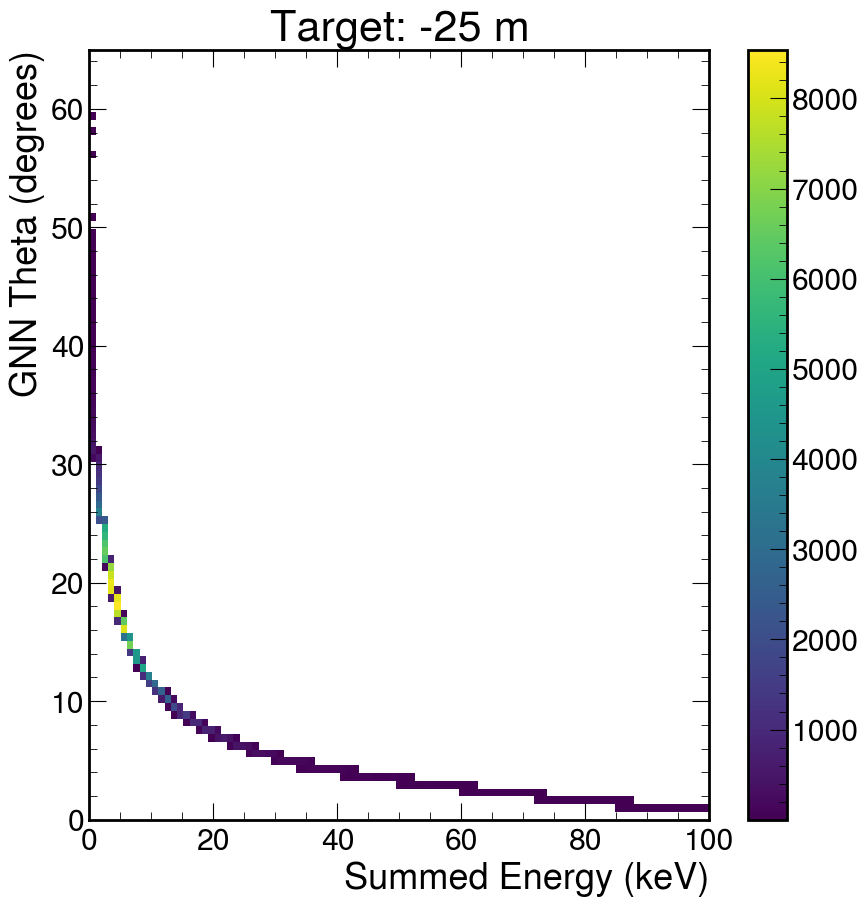

In [16]:
height = [1, -25, -50, -100]
energy_cut = [20,400,600,1500]
for i in range(1):
    plt.hist2d(np.array(data_energies[i])*1000,np.array(data_GNN[i]),bins=[np.linspace(0,100,100),np.linspace(0,65,100)],cmin=1)
    plt.ylabel("GNN Theta (degrees)")
    plt.xlabel("Summed Energy (keV)")
    plt.legend()
    plt.title(f'Target: {height[i+1]} m')
    plt.colorbar()
    plt.show()